In [3]:
import requests
import json
import csv
from bs4 import BeautifulSoup
import traceback
import cloudscraper
import pandas as pd
import numpy as np
import seaborn as sns
from decimal import Decimal
from re import sub
import matplotlib.pyplot as plt
%matplotlib inline

In [53]:
#define functions 
def get_cars(
  make="BMW", 
  model="5 SERIES", 
  postcode="SW1A 0AA", 
  radius=1500, 
  min_year=1995, 
  max_year=1995, 
  include_writeoff="include", 
  max_attempts_per_page=5, 
  verbose=False,
  min_price= 0,
  max_price = 99999):

    # To bypass Cloudflare protection
    scraper = cloudscraper.create_scraper()

    # Basic variables
    results = []
    n_this_year_results = 0

    url = "https://www.autotrader.co.uk/results-car-search"

    keywords = {}
    keywords["mileage"] = ["miles"]
    keywords["BHP"] = ["BHP"]
    keywords["transmission"] = ["Automatic", "Manual"]
    keywords["fuel"] = [
      "Petrol", 
      "Diesel", 
      "Electric", 
      "Hybrid – Diesel/Electric Plug-in", 
      "Hybrid – Petrol/Electric", 
      "Hybrid – Petrol/Electric Plug-in"
    ]
    keywords["owners"] = ["owners"]
    keywords["body"] = [
      "Coupe", 
      "Convertible", 
      "Estate", 
      "Hatchback", 
      "MPV", 
      "Pickup", 
      "SUV", 
      "Saloon"
    ]
    keywords["ULEZ"] = ["ULEZ"]
    keywords["year"] = [" reg)"]
    keywords["engine"] = ["engine"]

    # Set up parameters for query to autotrader.co.uk
    params = {
        "sort": "relevance",
        "postcode": postcode,
        "price-from" : min_price,
        "price-to" : max_price,
        "radius": radius,
        "make": make,
        "model": model,
        "search-results-price-type": "total-price",
        "search-results-year": "select-year",
    }

    if (include_writeoff == "include"):
        params["writeoff-categories"] = "on"
    elif (include_writeoff == "exclude"):
        params["exclude-writeoff-categories"] = "on"
    elif (include_writeoff == "writeoff-only"):
        params["only-writeoff-categories"] = "on"
        
    year = min_year
    page = 1
    attempt = 1

    try:
        while year <= max_year:
            params["year-from"] = year
            params["year-to"] = year
            params["page"] = page

            r = scraper.get(url, params=params)
            if verbose:
                print("Year:     ", year)
                print("Page:     ", page)
                print("Response: ", r)

            try:
                if r.status_code != 200:   # If not successful (e.g. due to bot protection)
                    print(r.status_code)
                    attempt = attempt + 1  # Log as an attempt
                    if attempt <= max_attempts_per_page:
                        if verbose:
                            print("Exception. Starting attempt #", attempt, "and keeping at page #", page)
                    else:
                        page = page + 1
                        attempt = 1
                        if verbose:
                            print("Exception. All attempts exhausted for this page. Skipping to next page #", page)

                else:

                    j = r.json()
                    s = BeautifulSoup(j["html"], features="html.parser")

                    articles = s.find_all("article", attrs={"data-standout-type":""})

                    # If no results or reached end of results...
                    if len(articles) == 0 or r.url[r.url.find("page=")+5:] != str(page):
                        if verbose:
                            print("Found total", n_this_year_results, "results for year", year, "across", page-1, "pages")
                            if year+1 <= max_year:
                                print("Moving on to year", year + 1)
                                print("---------------------------------")

                        # Increment year and reset relevant variables
                        type(year)
                        year = year + 1
                        page = 1
                        attempt = 1
                        n_this_year_results = 0
                    else:
                        for article in articles:
                            car = {}
                            car["name"] = article.find("h3", {"class": "product-card-details__title"}).text.strip()             
                            car["link"] = "https://www.autotrader.co.uk" + \
                                  article.find("a", {"class": "listing-fpa-link"})["href"][: article.find("a", {"class": "listing-fpa-link"})["href"] \
                                  .find("?")]
                            car["price"] = int(sub(r'[^\d.]', '', article.find("div", {"class": "product-card-pricing__price"}).text.strip()))

                            seller_info = article.find("ul", {"class": "product-card-seller-info__specs"}).text.strip()
                            car["seller"] = " ".join(seller_info.split())

                            key_specs_bs_list = article.find("ul", {"class": "listing-key-specs"}).find_all("li")
                            
                            for key_spec_bs_li in key_specs_bs_list:

                                key_spec_bs = key_spec_bs_li.text

                                if any(keyword in key_spec_bs for keyword in keywords["mileage"]):
                                    car["mileage"] = int(key_spec_bs[:key_spec_bs.find(" miles")].replace(",",""))
                                elif any(keyword in key_spec_bs for keyword in keywords["BHP"]):
                                    car["BHP"] = int(key_spec_bs[:key_spec_bs.find("BHP")])
                                elif any(keyword in key_spec_bs for keyword in keywords["transmission"]):
                                    car["transmission"] = key_spec_bs
                                elif any(keyword in key_spec_bs for keyword in keywords["fuel"]):
                                    car["fuel"] = key_spec_bs
                                elif any(keyword in key_spec_bs for keyword in keywords["owners"]):
                                    car["owners"] = int(key_spec_bs[:key_spec_bs.find(" owners")])
                                elif any(keyword in key_spec_bs for keyword in keywords["body"]):
                                    car["body"] = key_spec_bs
                                elif any(keyword in key_spec_bs for keyword in keywords["ULEZ"]):
                                    car["ULEZ"] = key_spec_bs
                                elif any(keyword in key_spec_bs for keyword in keywords["year"]):
                                    car["year"] = key_spec_bs
                                elif key_spec_bs[1] == "." and key_spec_bs[3] == "L":
                                    car["engine"] = float(sub(r'[^\d.]', '', key_spec_bs))

                            results.append(car)
                            n_this_year_results = n_this_year_results + 1

                        page = page + 1
                        attempt = 1

                        if verbose:
                            print("Car count: ", len(results))
                            print("---------------------------------")

            except KeyboardInterrupt:
                break

            except:
                traceback.print_exc()
                attempt = attempt + 1
                if attempt <= max_attempts_per_page:
                    if verbose:
                        print("Exception. Starting attempt #", attempt, "and keeping at page #", page)
                else:
                    page = page + 1
                    attempt = 1
                    if verbose:
                        print("Exception. All attempts exhausted for this page. Skipping to next page #", page)

    except KeyboardInterrupt:
        pass

    return pd.DataFrame(results)

def col_select(df,column):
    final_cols = []
    for i in df.columns:
        for j in column:
            if j in i:
                final_cols.append(i)
    
    return final_cols

def grouped_score(df,group,col_name):

    df = df.reset_index()
    
    car_match_gr = df.groupby(group).sum(numeric_only= True)
    count_cm_gr = df.groupby(group).count()

    price_dif_gr = car_match_gr['price_sell'] - car_match_gr['price_buy']
    mileage_ratio_gr = car_match_gr['mileage_sell']/car_match_gr['mileage_buy']
    engine_ratio_gr = car_match_gr['engine_buy'] /car_match_gr['engine_sell']

    score_gr = price_dif_gr * mileage_ratio_gr * engine_ratio_gr * (1/count_cm_gr['price_sell'])

    return df.merge(score_gr.reset_index(),how = 'left',on  = group ).rename({0:col_name},axis = 1).drop('index',axis = 1)

def postcode_add(df,postcode):
    for i in df.columns:
        concat_col = i + ' ' + postcode
        df = df.rename({i: concat_col.replace(' ','_')}, axis=1)

    return df

def retrieve_cars(make, model, postcode, radius, min_year, max_year, min_price, max_price,location_type):
    """
    Retrieve car listings based on specified search parameters.
    """
    cars = get_cars(
        make=make,
        model=model,
        postcode=postcode,
        radius=radius,
        min_year=min_year,
        max_year=max_year,
        min_price=min_price,
        max_price=max_price
    )
    # Clean up year and brand columns
    cars['year'] = cars['year'].dropna().apply(lambda x: int(str(x).split('(')[0]))
    cars['brand'] = cars['name'].apply(lambda x: x.split(' ')[0])
    cars['postcode'] = postcode
    cars = postcode_add(cars,location_type)
    return cars


In [42]:
#### parameters needed #####
#location 1 and location 2 to compare
#radius for each 
#car price and comparison
#minimum and maximum purchase price 

In [45]:
#leave as blank to include all within that range 
#postcode as 10 
#loation 1 is the area to buy the car and 2 is to sell 

make_buy="" 
model_buy="" 
postcode_buy="MK3 6JS" 
radius_buy=30
min_year_buy=2005 
max_year_buy=2010 
min_price_buy=10
max_price_buy = 10000

make_sell="" 
model_sell="" 
postcode_sell="DT1 3GJ" 
radius_sell=30
min_year_sell=2005 
max_year_sell=2010 
min_price_sell=10
max_price_sell = 10000


location_buy = retrieve_cars(make = make_buy, 
                           model = model_buy,
                           postcode = postcode_buy,
                           radius = radius_buy ,
                           min_year = min_year_buy ,
                           max_year = max_year_buy ,
                           min_price = min_price_buy,
                           max_price = max_price_buy,
                           location_type = 'buy' )

location_sell = retrieve_cars(make = make_sell, 
                           model = model_sell,
                           postcode = postcode_sell,
                           radius = radius_sell ,
                           min_year = min_year_sell ,
                           max_year = max_year_sell ,
                           min_price = min_price_sell,
                           max_price = max_price_sell,
                           location_type = 'sell' )

location_buy.to_csv('location_buy.csv')
location_sell.to_csv('location_sell.csv')



In [ ]:
#create the new data frames of each combination and iteration and combine 
#the original year on year combination 
car_match = location_buy.merge(location_sell, how = 'inner', left_on = col_select(location_buy,['name','year']),
                       right_on = col_select(location_sell,['name','year']))

price_dif = car_match['price_sell'] - car_match['price_buy']
mileage_ratio = car_match['mileage_sell']/car_match['mileage_buy']
engine_ratio = car_match['engine_buy']/car_match['engine_sell']

car_match['buy_score'] = price_dif * mileage_ratio * engine_ratio

car_match = grouped_score(car_match,'brand_buy')
car_match = grouped_score(car_match,'make_buy')

In [58]:
car_match = location_buy.merge(location_sell, how = 'inner', left_on = col_select(location_buy,['name','year']),
                       right_on = col_select(location_sell,['name','year']))

grouped_score(car_match,'name_buy','buy_score').drop('index',axis = 1)

,index,name_buy,link_buy,price_buy,seller_buy,year_buy,body_buy,mileage_buy,engine_buy,BHP_buy,...,body_sell,mileage_sell,engine_sell,BHP_sell,transmission_sell,fuel_sell,owners_sell,brand_sell,postcode_sell,buy_score
0,0,Renault Kangoo,https://www.autotrader.co.uk/car-details/20230...,2490,4.6 (331 reviews) milton keynes (6 miles),2005.0,MPV,73000.0,1.5,83.0,...,MPV,73000.0,1.5,83.0,Manual,Diesel,NaN,Renault,DT1 3GJ,0.000000
1,1,Peugeot 206,https://www.autotrader.co.uk/car-details/20230...,2490,4.6 (331 reviews) milton keynes (6 miles),2005.0,Hatchback,45000.0,1.1,60.0,...,Hatchback,45000.0,1.1,60.0,Manual,Petrol,NaN,Peugeot,DT1 3GJ,138.413272
2,2,Peugeot 206,https://www.autotrader.co.uk/car-details/20230...,1795,dunstable (13 miles),2005.0,Hatchback,42000.0,1.1,60.0,...,Hatchback,45000.0,1.1,60.0,Manual,Petrol,NaN,Peugeot,DT1 3GJ,138.413272
3,3,Peugeot 206,https://www.autotrader.co.uk/car-details/20230...,995,aylesbury (15 miles),2005.0,Hatchback,138081.0,1.1,60.0,...,Hatchback,45000.0,1.1,60.0,Manual,Petrol,NaN,Peugeot,DT1 3GJ,138.413272
4,4,Honda Civic,https://www.autotrader.co.uk/car-details/20230...,1990,5.0 (51 reviews) bedford (15 miles),2005.0,Hatchback,87516.0,1.6,108.0,...,Hatchback,100400.0,2.0,158.0,Manual,Petrol,2.0,Honda,DT1 3GJ,536.897919
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4687,4687,Fiat Doblo,https://www.autotrader.co.uk/car-details/20230...,3499,4.8 (48 reviews) bedmond (25 miles),2010.0,Estate,50200.0,1.4,77.0,...,Estate,28000.0,1.4,77.0,Manual,Petrol,6.0,Fiat,DT1 3GJ,446.772908
4688,4688,Mercedes-Benz GL Class,https://www.autotrader.co.uk/car-details/20230...,9999,4.8 (70 reviews) hemel hempstead (22 miles),2010.0,SUV,119000.0,3.0,NaN,...,SUV,139016.0,3.0,NaN,Automatic,Diesel,2.0,Mercedes-Benz,DT1 3GJ,248.049599
4689,4689,Chrysler Grand Voyager,https://www.autotrader.co.uk/car-details/20230...,6500,leighton buzzard (6 miles),2010.0,MPV,129422.0,2.8,NaN,...,MPV,86000.0,2.8,161.0,Automatic,Diesel,NaN,Chrysler,DT1 3GJ,-510.948905
4690,4690,Chrysler Grand Voyager,https://www.autotrader.co.uk/car-details/20230...,5950,bedford (13 miles),2010.0,MPV,118000.0,2.8,NaN,...,MPV,86000.0,2.8,161.0,Automatic,Diesel,NaN,Chrysler,DT1 3GJ,-510.948905


In [49]:
location_sell

,name_sell,link_sell,price_sell,seller_sell,year_sell,body_sell,mileage_sell,engine_sell,BHP_sell,transmission_sell,fuel_sell,owners_sell,brand_sell,postcode_sell
0,Ford Focus,https://www.autotrader.co.uk/car-details/20230...,1250,4.7 (45 reviews) bournemouth (26 miles),2005,Estate,107000.0,1.6,99.0,Manual,Petrol,NaN,Ford,DT1 3GJ
1,Volkswagen Polo,https://www.autotrader.co.uk/car-details/20230...,2995,4.7 (100 reviews) ringwood (29 miles),2005,Hatchback,81330.0,1.4,74.0,Automatic,Petrol,NaN,Volkswagen,DT1 3GJ
2,Renault Kangoo,https://www.autotrader.co.uk/car-details/20230...,2490,4.6 (331 reviews),2005,MPV,73000.0,1.5,83.0,Manual,Diesel,NaN,Renault,DT1 3GJ
3,Volvo V50,https://www.autotrader.co.uk/car-details/20230...,4990,4.9 (52 reviews),2005,Estate,57036.0,2.0,136.0,Manual,Diesel,2.0,Volvo,DT1 3GJ
4,Peugeot 206,https://www.autotrader.co.uk/car-details/20230...,2490,4.6 (331 reviews),2005,Hatchback,45000.0,1.1,60.0,Manual,Petrol,NaN,Peugeot,DT1 3GJ
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
610,Honda Cr-V,https://www.autotrader.co.uk/car-details/20230...,9495,5.0 (11 reviews) poole (24 miles),2010,SUV,64900.0,2.0,NaN,Automatic,Petrol,2.0,Honda,DT1 3GJ
611,Jaguar XF,https://www.autotrader.co.uk/car-details/20230...,6495,4.9 (75 reviews) ringwood (29 miles),2010,Saloon,77000.0,3.0,NaN,Automatic,Petrol,4.0,Jaguar,DT1 3GJ
612,Volvo XC60,https://www.autotrader.co.uk/car-details/20230...,7995,3.8 (95 reviews) christchurch (29 miles),2010,SUV,85000.0,2.4,NaN,Automatic,Diesel,NaN,Volvo,DT1 3GJ
613,Mercedes-Benz A Class,https://www.autotrader.co.uk/car-details/20230...,7500,4.9 (75 reviews) ringwood (29 miles),2010,Hatchback,20000.0,2.0,82.0,Automatic,Diesel,NaN,Mercedes-Benz,DT1 3GJ


In [48]:
car_match

,name_1,link_1,price_1,seller_1,year_1,body_1,mileage_1,engine_1,BHP_1,transmission_1,...,engine_2,BHP_2,transmission_2,fuel_2,owners_2,brand_2,postcode_2,buy_score,score_brand_1,score_name_1
0,Renault Kangoo,https://www.autotrader.co.uk/car-details/20230...,2490,4.6 (331 reviews) milton keynes (6 miles),2005.0,MPV,73000.0,1.5,83.0,Manual,...,1.5,83.0,Manual,Diesel,NaN,Renault,DT1 3GJ,0.000000,596.590103,0.000000
1,Peugeot 206,https://www.autotrader.co.uk/car-details/20230...,2490,4.6 (331 reviews) milton keynes (6 miles),2005.0,Hatchback,45000.0,1.1,60.0,Manual,...,1.1,60.0,Manual,Petrol,NaN,Peugeot,DT1 3GJ,0.000000,159.644308,138.413272
2,Peugeot 206,https://www.autotrader.co.uk/car-details/20230...,1795,dunstable (13 miles),2005.0,Hatchback,42000.0,1.1,60.0,Manual,...,1.1,60.0,Manual,Petrol,NaN,Peugeot,DT1 3GJ,744.642857,159.644308,138.413272
3,Peugeot 206,https://www.autotrader.co.uk/car-details/20230...,995,aylesbury (15 miles),2005.0,Hatchback,138081.0,1.1,60.0,Manual,...,1.1,60.0,Manual,Petrol,NaN,Peugeot,DT1 3GJ,487.214027,159.644308,138.413272
4,Honda Civic,https://www.autotrader.co.uk/car-details/20230...,1990,5.0 (51 reviews) bedford (15 miles),2005.0,Hatchback,87516.0,1.6,108.0,Manual,...,2.0,158.0,Manual,Petrol,2.0,Honda,DT1 3GJ,1197.696421,525.983469,598.364280
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4746,Mercedes-Benz GL Class,https://www.autotrader.co.uk/car-details/20230...,9999,4.8 (70 reviews) hemel hempstead (22 miles),2010.0,SUV,119000.0,3.0,NaN,Automatic,...,3.0,NaN,Automatic,Diesel,2.0,Mercedes-Benz,DT1 3GJ,-822.413983,797.297247,248.049599
4747,Chrysler Grand Voyager,https://www.autotrader.co.uk/car-details/20230...,6500,leighton buzzard (6 miles),2010.0,MPV,129422.0,2.8,NaN,Automatic,...,2.8,161.0,Automatic,Diesel,NaN,Chrysler,DT1 3GJ,-671.137828,-1493.465240,-565.963635
4748,Chrysler Grand Voyager,https://www.autotrader.co.uk/car-details/20230...,6500,leighton buzzard (6 miles),2010.0,MPV,129422.0,2.8,NaN,Automatic,...,2.8,161.0,Automatic,Diesel,NaN,Chrysler,DT1 3GJ,-671.137828,-1493.465240,-565.963635
4749,Chrysler Grand Voyager,https://www.autotrader.co.uk/car-details/20230...,5950,bedford (13 miles),2010.0,MPV,118000.0,2.8,NaN,Automatic,...,2.8,161.0,Automatic,Diesel,NaN,Chrysler,DT1 3GJ,-335.254237,-1493.465240,-565.963635


In [38]:
#give a take a year for model to model.
#minimal mileage differen between both.
#find the price difference 
location_buy = pd.read_csv('location_buy.csv').drop(['Unnamed: 0'],axis = 1)
location_sell = pd.read_csv('location_sell.csv').drop(['Unnamed: 0'],axis = 1)

car_match = location_buy.merge(location_sell, how = 'inner', left_on = col_select(location_buy,['name','year']),
                       right_on = col_select(location_sell,['name','year']))

price_dif = car_match['price_sell'] - car_match['price_buy']
mileage_ratio = car_match['mileage_sell']/car_match['mileage_buy']
engine_ratio = car_match['engine_buy']/car_match['engine_sell']

car_match['buy_score'] = price_dif * mileage_ratio * engine_ratio


car_match = grouped_score(car_match,'brand_buy')
car_match = grouped_score(car_match,'name_buy')

FileNotFoundError: [Errno 2] No such file or directory: 'location_buy.csv'

In [37]:
grouped_score(car_match,'make_buy')

KeyError: 'make_buy'

In [28]:
car_match

,name_1,link_1,price_1,seller_1,year_1,body_1,mileage_1,engine_1,BHP_1,transmission_1,...,engine_2,BHP_2,transmission_2,fuel_2,owners_2,brand_2,postcode_2,buy_score,score_brand_1,score_name_1
0,Renault Kangoo,https://www.autotrader.co.uk/car-details/20230...,2490,4.6 (331 reviews) milton keynes (6 miles),2005.0,MPV,73000.0,1.5,83.0,Manual,...,1.5,83.0,Manual,Diesel,NaN,Renault,DT1 3GJ,0.000000,596.590103,0.000000
1,Peugeot 206,https://www.autotrader.co.uk/car-details/20230...,2490,4.6 (331 reviews) milton keynes (6 miles),2005.0,Hatchback,45000.0,1.1,60.0,Manual,...,1.1,60.0,Manual,Petrol,NaN,Peugeot,DT1 3GJ,0.000000,159.644308,138.413272
2,Peugeot 206,https://www.autotrader.co.uk/car-details/20230...,1795,dunstable (13 miles),2005.0,Hatchback,42000.0,1.1,60.0,Manual,...,1.1,60.0,Manual,Petrol,NaN,Peugeot,DT1 3GJ,744.642857,159.644308,138.413272
3,Peugeot 206,https://www.autotrader.co.uk/car-details/20230...,995,aylesbury (15 miles),2005.0,Hatchback,138081.0,1.1,60.0,Manual,...,1.1,60.0,Manual,Petrol,NaN,Peugeot,DT1 3GJ,487.214027,159.644308,138.413272
4,Honda Civic,https://www.autotrader.co.uk/car-details/20230...,1990,5.0 (51 reviews) bedford (15 miles),2005.0,Hatchback,87516.0,1.6,108.0,Manual,...,2.0,158.0,Manual,Petrol,2.0,Honda,DT1 3GJ,1197.696421,525.983469,598.364280
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4746,Mercedes-Benz GL Class,https://www.autotrader.co.uk/car-details/20230...,9999,4.8 (70 reviews) hemel hempstead (22 miles),2010.0,SUV,119000.0,3.0,NaN,Automatic,...,3.0,NaN,Automatic,Diesel,2.0,Mercedes-Benz,DT1 3GJ,-822.413983,797.297247,248.049599
4747,Chrysler Grand Voyager,https://www.autotrader.co.uk/car-details/20230...,6500,leighton buzzard (6 miles),2010.0,MPV,129422.0,2.8,NaN,Automatic,...,2.8,161.0,Automatic,Diesel,NaN,Chrysler,DT1 3GJ,-671.137828,-1493.465240,-565.963635
4748,Chrysler Grand Voyager,https://www.autotrader.co.uk/car-details/20230...,6500,leighton buzzard (6 miles),2010.0,MPV,129422.0,2.8,NaN,Automatic,...,2.8,161.0,Automatic,Diesel,NaN,Chrysler,DT1 3GJ,-671.137828,-1493.465240,-565.963635
4749,Chrysler Grand Voyager,https://www.autotrader.co.uk/car-details/20230...,5950,bedford (13 miles),2010.0,MPV,118000.0,2.8,NaN,Automatic,...,2.8,161.0,Automatic,Diesel,NaN,Chrysler,DT1 3GJ,-335.254237,-1493.465240,-565.963635


In [23]:
car_match = grouped_score(car_match,[])

ValueError: No group keys passed!

In [21]:
#top 10 cars and urls
car_match.sort_values(by = 'buy_score' ,ascending= False)[0:20][['name_buy','price_buy','price_sell','postcode_buy','postcode_sell','mileage_buy','mileage_sell','engine_buy','engine_sell','buy_score','link_buy','link_sell','score_brand_buy']]

,name_1,price_1,price_2,postcode_1,postcode_2,mileage_1,mileage_2,engine_1,engine_2,buy_score,link_1,link_2,score_brand_1
12,Honda Civic,3495,9995,MK3 6JS,DT1 3GJ,36700.0,79900.0,1.6,2.0,11320.980926,https://www.autotrader.co.uk/car-details/20230...,https://www.autotrader.co.uk/car-details/20221...,525.983469
21,Honda Civic,3495,9995,MK3 6JS,DT1 3GJ,45000.0,79900.0,1.6,2.0,9232.888889,https://www.autotrader.co.uk/car-details/20230...,https://www.autotrader.co.uk/car-details/20221...,525.983469
2220,Vauxhall Astra,3095,6250,MK3 6JS,DT1 3GJ,21000.0,71350.0,1.4,2.0,7503.641667,https://www.autotrader.co.uk/car-details/20230...,https://www.autotrader.co.uk/car-details/20230...,388.597074
15,Honda Civic,2490,9995,MK3 6JS,DT1 3GJ,73980.0,79900.0,1.6,2.0,6484.449851,https://www.autotrader.co.uk/car-details/20230...,https://www.autotrader.co.uk/car-details/20221...,525.983469
18,Honda Civic,2190,9995,MK3 6JS,DT1 3GJ,85000.0,79900.0,1.6,2.0,5869.360000,https://www.autotrader.co.uk/car-details/20230...,https://www.autotrader.co.uk/car-details/20221...,525.983469
6,Honda Civic,1990,9995,MK3 6JS,DT1 3GJ,87516.0,79900.0,1.6,2.0,5846.697747,https://www.autotrader.co.uk/car-details/20230...,https://www.autotrader.co.uk/car-details/20221...,525.983469
2507,Renault Clio,1350,7300,MK3 6JS,DT1 3GJ,66543.0,85400.0,1.5,2.0,5727.086245,https://www.autotrader.co.uk/car-details/20230...,https://www.autotrader.co.uk/car-details/20230...,596.590103
448,MINI Hatch,1494,6495,MK3 6JS,DT1 3GJ,95219.0,95012.0,1.6,1.6,4990.128147,https://www.autotrader.co.uk/car-details/20230...,https://www.autotrader.co.uk/car-details/20211...,708.371866
1564,MINI Hatch,1375,7950,MK3 6JS,DT1 3GJ,84015.0,70238.0,1.4,1.6,4809.712477,https://www.autotrader.co.uk/car-details/20230...,https://www.autotrader.co.uk/car-details/20220...,708.371866
855,BMW 3 Series,4250,9500,MK3 6JS,DT1 3GJ,60127.0,81000.0,2.0,3.0,4715.019875,https://www.autotrader.co.uk/car-details/20230...,https://www.autotrader.co.uk/car-details/20230...,1241.564711


In [12]:
score_gr

brand_1
Alfa              578.391030
Audi             -116.655646
BMW              1241.564711
Chevrolet         231.742609
Chrysler        -1493.465240
Citroen            61.764569
Daihatsu            0.000000
Fiat             -391.904988
Ford              632.694223
Honda             525.983469
Hyundai           274.409790
Jaguar            334.420635
KIA               483.898804
Land              374.047545
Lexus             728.298969
MINI              708.371866
Mazda             835.654535
Mazda2           1088.115022
Mazda3           1644.835733
Mazda5           1653.379554
Mercedes-Benz     797.297247
Mitsubishi        -56.504727
Nissan            716.765846
Peugeot           159.644308
Porsche          -609.454806
Renault           596.590103
SEAT             -523.123958
SKODA            -803.734733
Saab             -755.939005
Smart             629.288990
Subaru          -5326.097358
Suzuki            144.660793
Toyota           -156.023986
Vauxhall          388.597074
Volksw

<BarContainer object of 4 artists>

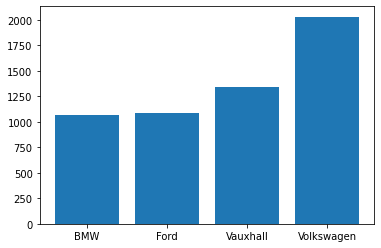

In [19]:
plt.bar(x = score_gr.index,height = score_gr.values)